# Thrombolysis prediction shap

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

## Load data

In [2]:
data = pd.read_csv('../data/thrombolysis_xgb_data_2017_2019.csv')

## Anonymise stroke teams

In [3]:
# Anomyise stroke teams
teams = data['stroke team'].unique()


In [4]:
# Shuffle teams
np.random.seed(42)
np.random.shuffle(teams)
rename_dict = {team: f'team_{i+100}' for i, team in enumerate(teams)}

# Rename teams
data['stroke team'] = data['stroke team'].map(rename_dict)
data.head()

,stroke team,age,infarction,stroke severity,onset-to-arrival time,precise onset known,onset during sleep,use of AF anticoagulants,prior disability,arrival-to-scan time,thrombolysis
0,team_115,52.5,1,2,78,1,0,0,0,87.0,0
1,team_194,57.5,1,7,96,0,1,0,0,58.0,0
2,team_197,67.5,1,2,164,1,0,0,0,18.0,0
3,team_164,62.5,1,5,150,0,0,0,0,48.0,1
4,team_101,87.5,1,2,65,1,0,0,4,7.0,0


## Split data into X and y

In [5]:
X = data.drop(['thrombolysis'], axis=1)
y = data['thrombolysis']

## Fit XGBoost model

In [6]:
# One hot encode hospitals
X_train_hosp = (pd.get_dummies(X['stroke team'], prefix='team'))
X_train = pd.concat([X, X_train_hosp], axis=1)
X_train.drop('stroke team', axis=1, inplace=True)

# Create XGBoost model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
model.fit(X_train, y)

# Save model
pickle.dump(
    model, open('./output/thrombolysis_xgb_model_anonymised_2017_2019.pkl', 'wb'))

# Get predictions
y_pred = model.predict(X_train)
y_pred_proba = model.predict_proba(X_train)[:, 1]
accuracy = np.mean(y_pred == y)
print(f'\nAccuracy: {accuracy:.3f}')



Accuracy: 0.886


## Get SHAP values

In [7]:
# Set up explainer using the model and feature values from training set
explainer = shap.TreeExplainer(model, X_train)

# GetShapley values along with base and feature values
shap_values_extended = explainer(X_train)
shap_values = shap_values_extended.values

# Save Explainer
pickle.dump(
    explainer, open('./output/thrombolysis_xgb_explainer_anonymised_2017_2019.pkl', 'wb'))

100%|===================| 69500/69510 [01:39<00:00]        

## Summary SHAP plot

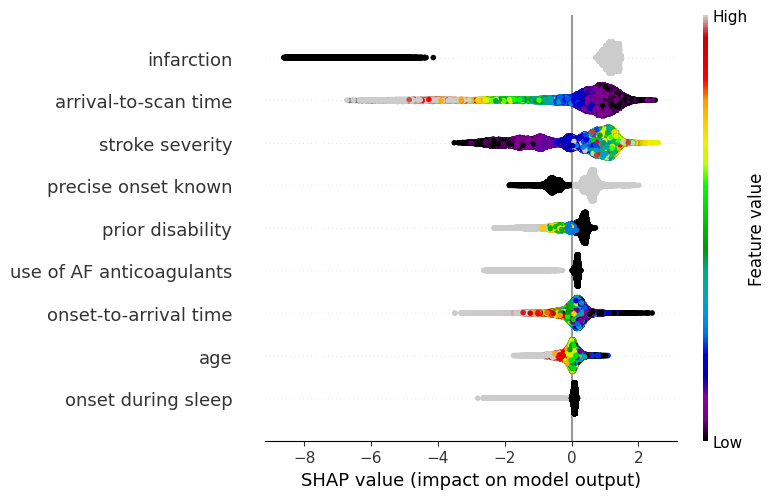

In [8]:
shap.summary_plot(
    shap_values=shap_values,
    features=X_train,
    max_display=9,
    cmap=plt.get_cmap('nipy_spectral'), show=False)


## Save team names

In [9]:
teams_df = pd.Series(rename_dict)
teams_df

Chesterfield Royal                      team_100
Fairfield General Hospital              team_101
Derriford Hospital                      team_102
Eastbourne District General Hospital    team_103
Hull Royal Infirmary                    team_104
                                          ...   
Torbay Hospital                         team_209
Musgrove Park Hospital                  team_210
Salisbury District Hospital             team_211
Queen Elizabeth Hospital Edgbaston      team_212
West Wales General                      team_213
Length: 114, dtype: object

In [10]:
teams_df.to_csv('./output/team_identities.csv', index=True)